In [28]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
from datetime import datetime

class SpecializedAICrawler:
    def __init__(self):
        self.all_reviews = []
        self.targets = {
            '디자인': {
                'tool': 'Canva',
                'url': 'https://www.capterra.com/p/168956/Canva/reviews/'
            },
            '디자인_전문': {
                'tool': 'Figma',
                'url': 'https://www.capterra.com/p/175027/Figma/reviews/'
            },
            'IT_SW': {
                'tool': 'GitHub Copilot',
                'url': 'https://www.capterra.com/p/10011215/Copilot/reviews/'
            },
            '경영_글로벌': {
                'tool': 'Grammarly',
                'url': 'https://www.capterra.com/p/170306/Grammarly-Business/reviews/'
            },
            '공공_행정': {
                'tool': 'Monday.com',
                'url': 'https://www.capterra.com/p/147657/monday-com/reviews/'
            },
            '금융_물류': {
                'tool': 'Tableau',
                'url': 'https://www.capterra.com/p/208764/Tableau/reviews/'
            },
            '영상_광고': {
                'tool': 'Adobe Premiere Pro',
                'url': 'https://www.capterra.com/p/233456/Adobe-Premiere-Pro/reviews/'
            }
        }
        
        options = webdriver.ChromeOptions()
        options.add_argument('--disable-blink-features=AutomationControlled')
        options.add_argument('--start-maximized')
        options.add_argument('--disable-logging')
        options.add_argument('--log-level=3')
        options.add_experimental_option('excludeSwitches', ['enable-logging'])
        self.driver = webdriver.Chrome(options=options)
        self.wait = WebDriverWait(self.driver, 10)
    
    def extract_job_title(self, card_element):
        try:
            full_text = card_element.text
            lines = [line.strip() for line in full_text.split('\n') if line.strip()]
            
            exclude = ['January', 'February', 'March', 'April', 'May', 'June', 
                       'July', 'August', 'September', 'October', 'November', 'December',
                       'Used the software', 'Pros', 'Cons', 'Review Source',
                       'Continue reading', 'View less']
            
            for i, line in enumerate(lines):
                if '.' in line and len(line) < 30:
                    if i + 1 < len(lines):
                        potential_job = lines[i + 1]
                        if not any(ex in potential_job for ex in exclude) and len(potential_job) < 80:
                            if not ('202' in potential_job and ',' in potential_job):
                                return potential_job
                
                if not any(ex in line for ex in exclude) and 5 < len(line) < 80:
                    if not ('202' in line and ',' in line) and not '.0' in line:
                        return line
            
            return "N/A"
        except:
            return "N/A"
    
    def extract_review_data(self, card_element, field, tool_name):
        try:
            full_text = card_element.text
            lines = [line.strip() for line in full_text.split('\n') if line.strip()]
            
            reviewer_name = "N/A"
            for line in lines:
                if '.' in line and len(line) < 30:
                    reviewer_name = line
                    break
            
            job_title = self.extract_job_title(card_element)
            
            review_title = "N/A"
            for line in lines:
                if line.startswith('"') and line.endswith('"'):
                    review_title = line
                    break
            
            rating = "N/A"
            for line in lines:
                if '.0' in line and len(line) < 10:
                    try:
                        float(line)
                        rating = line
                        break
                    except:
                        continue
            
            date = "N/A"
            for line in lines:
                if '202' in line and ',' in line and len(line) < 20:
                    date = line
                    break
            
            return {
                'field': field,
                'ai_tool': tool_name,
                'reviewer_name': reviewer_name,
                'job_title': job_title,
                'rating': rating,
                'review_title': review_title,
                'date': date
            }
        except:
            return None
    
    def crawl_page(self, field, tool_name):
        try:
            continue_buttons = self.driver.find_elements(By.XPATH, "//button[contains(text(), 'Continue reading')]")
            for btn in continue_buttons[:5]:
                try:
                    self.driver.execute_script("arguments[0].scrollIntoView(true);", btn)
                    time.sleep(0.3)
                    btn.click()
                    time.sleep(0.2)
                except:
                    continue
        except:
            pass
        
        review_cards = self.driver.find_elements(By.XPATH, "//button[contains(text(), 'Continue reading')]/../..")
        
        if len(review_cards) == 0:
            review_cards = self.driver.find_elements(By.XPATH, "//button[contains(text(), 'View less')]/../..")
        
        if len(review_cards) == 0:
            review_cards = self.driver.find_elements(By.CSS_SELECTOR, "article, div[class*='review']")
        
        page_reviews = []
        for card in review_cards:
            data = self.extract_review_data(card, field, tool_name)
            if data:
                page_reviews.append(data)
        
        return page_reviews
    
    def go_to_page_url(self, base_url, page_num):
        try:
            url = base_url if page_num == 1 else f"{base_url}?page={page_num}"
            self.driver.get(url)
            time.sleep(2)
            
            try:
                self.wait.until(EC.presence_of_element_located((By.TAG_NAME, "body")))
            except TimeoutException:
                return False
            
            return True
        except:
            return False
    
    def crawl_tool(self, field, tool_info, max_reviews=2000):
        tool_name = tool_info['tool']
        base_url = tool_info['url']
        
        try:
            collected = 0
            page = 1
            no_data_count = 0
            
            while collected < max_reviews:
                if not self.go_to_page_url(base_url, page):
                    break
                
                for _ in range(2):
                    self.driver.execute_script("window.scrollBy(0, 800);")
                    time.sleep(0.5)
                
                page_reviews = self.crawl_page(field, tool_name)
                
                if len(page_reviews) == 0:
                    no_data_count += 1
                    if no_data_count >= 3:
                        break
                else:
                    no_data_count = 0
                    
                    for review in page_reviews:
                        if collected >= max_reviews:
                            break
                        self.all_reviews.append(review)
                        collected += 1
                
                if collected >= max_reviews:
                    break
                
                page += 1
                time.sleep(1.5)
            
            return collected
            
        except:
            return 0
    
    def run(self, max_reviews_per_tool=2000):
        results = {}
        
        for field, tool_info in self.targets.items():
            count = self.crawl_tool(field, tool_info, max_reviews_per_tool)
            results[f"{field} - {tool_info['tool']}"] = count
            time.sleep(2)
        
        if self.all_reviews:
            df = pd.DataFrame(self.all_reviews)
            
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            filename = f'specialized_ai_reviews_raw_{timestamp}.csv'
            df.to_csv(filename, index=False, encoding='utf-8-sig')
            
            print("\n크롤링 결과:")
            for tool, count in results.items():
                print(f"  {tool}: {count}개")
            print(f"\n총 수집: {sum(results.values())}개")
            print(f"저장: {filename}")
            
            self.driver.quit()
            return df
        else:
            self.driver.quit()
            return None


if __name__ == "__main__":
    crawler = SpecializedAICrawler()
    df = crawler.run(max_reviews_per_tool=2000)


크롤링 결과:
  디자인 - Canva: 2000개
  디자인_전문 - Figma: 841개
  IT_SW - GitHub Copilot: 31개
  경영_글로벌 - Grammarly: 2000개
  공공_행정 - Monday.com: 2000개
  금융_물류 - Tableau: 2000개
  영상_광고 - Adobe Premiere Pro: 559개

총 수집: 9431개
저장: specialized_ai_reviews_raw_20251213_212227.csv


In [42]:
import pandas as pd
import numpy as np
from collections import Counter

class JobAnalyzer:
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file, encoding='utf-8-sig')
        self.original_count = len(self.df)
        
        print(f"데이터 로드: {self.original_count}개 리뷰")
        print(f"전공 분야: {self.df['field'].unique()}")
        print(f"AI 툴: {self.df['ai_tool'].unique()}\n")
    
    def explore_jobs(self, top_n=50):
        print(f"직업 분포 Top {top_n}\n")
        
        job_counts = self.df['job_title'].value_counts().head(top_n)
        
        for idx, (job, count) in enumerate(job_counts.items(), 1):
            print(f"{idx:2d}. {job[:50]:<52} : {count:4d}개")
        
        print(f"\n총 고유 직업 수: {self.df['job_title'].nunique()}개")
        print(f"N/A 비율: {(self.df['job_title'] == 'N/A').sum() / len(self.df) * 100:.1f}%\n")
        
        return job_counts
    
    def classify_jobs(self):
        job_mapping = {
            '개발자': {
                'keywords': ['engineer', 'developer', 'programmer', 'coder', 
                            'software', 'backend', 'frontend', 'fullstack', 
                            'web developer', 'mobile developer', 'devops'],
                'exact': []
            },
            '디자이너': {
                'keywords': ['designer', 'graphic', 'ux', 'ui', 'visual', 
                            'creative', 'artist', 'illustrator', 'art director'],
                'exact': []
            },
            '경영진': {
                'keywords': ['ceo', 'cto', 'coo', 'founder', 'co-founder', 
                            'president', 'vp', 'owner', 'chief'],
                'exact': []
            },
            '관리자': {
                'keywords': ['manager', 'director', 'head', 'lead', 
                            'supervisor', 'coordinator'],
                'exact': []
            },
            '마케팅': {
                'keywords': ['marketing', 'marketer', 'brand', 'social media',
                            'content creator', 'seo', 'growth'],
                'exact': []
            },
            '영상_미디어': {
                'keywords': ['video', 'editor', 'producer', 'filmmaker', 
                            'videographer', 'photographer', 'media'],
                'exact': []
            },
            '학생': {
                'keywords': ['student', 'undergraduate', 'graduate', 'intern'],
                'exact': []
            },
            '프리랜서': {
                'keywords': ['freelance', 'freelancer', 'self-employed', 
                            'independent', 'consultant'],
                'exact': []
            },
            '분석가': {
                'keywords': ['analyst', 'data', 'researcher', 'scientist'],
                'exact': []
            },
            '교육': {
                'keywords': ['teacher', 'educator', 'instructor', 'professor', 
                            'trainer', 'tutor'],
                'exact': []
            },
            '사무직': {
                'keywords': ['administrator', 'assistant', 'coordinator', 
                            'specialist', 'officer', 'representative'],
                'exact': []
            },
            '기타_전문직': {
                'keywords': ['writer', 'author', 'blogger', 'accountant', 
                            'lawyer', 'architect'],
                'exact': []
            }
        }
        
        def classify(job_title):
            if pd.isna(job_title) or job_title == 'N/A':
                return '정보없음'
            
            if 'verified reviewer' in job_title.lower():
                return '정보없음'
            
            job_lower = job_title.lower()
            
            for category, patterns in job_mapping.items():
                if any(keyword in job_lower for keyword in patterns['keywords']):
                    return category
                if job_lower in patterns['exact']:
                    return category
            
            return '기타'
        
        self.df['job_category'] = self.df['job_title'].apply(classify)
        
        print("직업 분류 결과\n")
        category_counts = self.df['job_category'].value_counts()
        
        for category, count in category_counts.items():
            percentage = count / len(self.df) * 100
            print(f"{category:<15} : {count:4d}개 ({percentage:5.1f}%)")
        
        print()
        return category_counts
    
    def analyze_by_field(self):
        print("전공별 주요 직업 분포\n")
        
        for field in self.df['field'].unique():
            field_df = self.df[self.df['field'] == field]
            tool = field_df['ai_tool'].iloc[0]
            
            print(f"[{field}] {tool} (총 {len(field_df)}개 리뷰)")
            
            top_categories = field_df['job_category'].value_counts().head(5)
            for idx, (cat, count) in enumerate(top_categories.items(), 1):
                percentage = count / len(field_df) * 100
                print(f"  {idx}. {cat:<15} : {count:3d}개 ({percentage:4.1f}%)")
            
            print()
    
    def export_results(self, output_dir=r'C:\Users\pc'):
        import os
        output_file = os.path.join(output_dir, 'specialized_ai_reviews_analyzed.csv')
        self.df.to_csv(output_file, index=False, encoding='utf-8-sig')
        print(f"분석 결과 저장: {output_file}")
        
        summary_file = os.path.join(output_dir, 'specialized_ai_reviews_summary.txt')
        with open(summary_file, 'w', encoding='utf-8') as f:
            f.write("AI 툴 리뷰 분석 요약\n\n")
            f.write(f"총 리뷰 수: {len(self.df)}개\n")
            f.write(f"전공 분야: {len(self.df['field'].unique())}개\n")
            f.write(f"AI 툴: {len(self.df['ai_tool'].unique())}개\n\n")
            
            f.write("직업 카테고리 분포\n")
            for cat, count in self.df['job_category'].value_counts().items():
                percentage = count / len(self.df) * 100
                f.write(f"{cat:<15} : {count:4d}개 ({percentage:5.1f}%)\n")
        
        print(f"요약 통계 저장: {summary_file}\n")
    
    def create_crosstab(self, output_dir=r'C:\Users\pc'):
        print("전공 × 직업 카테고리 크로스탭\n")
        
        crosstab = pd.crosstab(
            self.df['field'], 
            self.df['job_category'],
            margins=True,
            margins_name='합계'
        )
        
        print(crosstab)
        
        import os
        crosstab_file = os.path.join(output_dir, 'field_job_crosstab.csv')
        crosstab.to_csv(crosstab_file, encoding='utf-8-sig')
        print(f"\n크로스탭 저장: {crosstab_file}\n")
        
        return crosstab
    
    def validate_classification(self, category, sample_size=10):
        print(f"'{category}' 분류 검증 (샘플 {sample_size}개)\n")
        
        category_df = self.df[self.df['job_category'] == category]
        
        if len(category_df) == 0:
            print(f"'{category}' 카테고리에 데이터 없음\n")
            return
        
        samples = category_df['job_title'].value_counts().head(sample_size)
        
        for idx, (job, count) in enumerate(samples.items(), 1):
            print(f"{idx:2d}. {job[:60]:<62} : {count}개")
        
        print(f"\n'{category}' 총 {len(category_df)}개\n")


if __name__ == "__main__":
    csv_path = r'C:\Users\pc\specialized_ai_reviews_raw_20251213_212227.csv'
    
    analyzer = JobAnalyzer(csv_path)
    job_dist = analyzer.explore_jobs(top_n=50)
    category_dist = analyzer.classify_jobs()
    analyzer.analyze_by_field()
    crosstab = analyzer.create_crosstab()
    
    for category in ['개발자', '디자이너', '관리자', '학생', '프리랜서']:
        analyzer.validate_classification(category, sample_size=10)
    
    analyzer.export_results()
    
    print("분석 완료")
    print(f"결과 파일 위치: C:\\Users\\pc\\")


데이터 로드: 9431개 리뷰
전공 분야: ['디자인' '디자인_전문' 'IT_SW' '경영_글로벌' '공공_행정' '금융_물류' '영상_광고']
AI 툴: ['Canva' 'Figma' 'GitHub Copilot' 'Grammarly' 'Monday.com' 'Tableau'
 'Adobe Premiere Pro']

직업 분포 Top 50

 1. Verified Reviewer                                    : 1571개
 2. Owner                                                :  204개
 3. CEO                                                  :  163개
 4. Student                                              :  123개
 5. Freelancer                                           :  109개
 6. Director                                             :   89개
 7. Manager                                              :   67개
 8. Founder                                              :   64개
 9. Project Manager                                      :   60개
10. Graphic Designer                                     :   59개
11. Teacher                                              :   55개
12. Marketing Manager                                    :   54개
13. Designer             

In [43]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

csv_path = r"C:\Users\pc\specialized_ai_reviews_raw_20251213_212227.csv"
df = pd.read_csv(csv_path)

print(f"총 데이터: {len(df)}개\n")
print("데이터 샘플")
print(df.head())

def categorize_role_advanced(role):
    if pd.isna(role) or role == '':
        return '기타'
    
    role_lower = str(role).lower()
    
    design_keywords = [
        'designer', 'design', 'graphic', 'visual', 'ux', 'ui', 
        'art director', 'creative', 'illustrator', 'animator', 'motion',
        'video editor', 'editor', 'photo', 'multimedia', '3d artist'
    ]
    
    engineering_keywords = [
        'engineer', 'developer', 'programmer', 'software', 'devops',
        'backend', 'frontend', 'full stack', 'fullstack', 'qa',
        'quality assurance', 'sysadmin', 'network', 'security'
    ]
    
    data_keywords = [
        'data scientist', 'data analyst', 'analyst', 'analytics', 
        'business intelligence', 'bi ', 'research', 'insights', 'statistician'
    ]
    
    product_keywords = [
        'product manager', 'product owner', 'product lead', 'product director'
    ]
    
    project_keywords = [
        'project manager', 'program manager', 'scrum master', 
        'coordinator', 'project lead'
    ]
    
    marketing_keywords = [
        'marketing', 'brand', 'content', 'social media', 'seo', 'sem',
        'digital marketing', 'campaign', 'copywriter', 'communications'
    ]
    
    sales_keywords = [
        'sales', 'business development', 'account executive', 
        'account manager', 'customer success'
    ]
    
    media_keywords = [
        'producer', 'journalist', 'writer', 'author', 'media',
        'broadcast', 'film', 'video production', 'cinematographer'
    ]
    
    education_keywords = [
        'teacher', 'professor', 'instructor', 'educator', 'tutor',
        'trainer', 'student', 'lecturer'
    ]
    
    healthcare_keywords = [
        'doctor', 'nurse', 'physician', 'medical', 'healthcare', 'therapist'
    ]
    
    finance_keywords = [
        'finance', 'accountant', 'accounting', 'financial', 'cfo',
        'auditor', 'treasurer'
    ]
    
    hr_keywords = [
        'hr ', 'human resources', 'recruiter', 'recruiting', 'talent'
    ]
    
    operations_keywords = [
        'operations', 'ops ', 'supply chain', 'logistics', 
        'admin', 'assistant', 'office manager'
    ]
    
    consulting_keywords = [
        'consultant', 'consulting', 'advisor', 'strategist'
    ]
    
    legal_keywords = [
        'lawyer', 'attorney', 'legal', 'paralegal'
    ]
    
    executive_keywords = [
        'ceo', 'cto', 'coo', 'cmo', 'founder', 'president',
        'vice president', 'vp ', 'director', 'head of', 'chief',
        'owner', 'manager'
    ]
    
    for keyword in product_keywords:
        if keyword in role_lower:
            return '제품 관리'
    
    for keyword in project_keywords:
        if keyword in role_lower:
            return '프로젝트 관리'
    
    for keyword in design_keywords:
        if keyword in role_lower:
            return '디자인/크리에이티브'
    
    for keyword in engineering_keywords:
        if keyword in role_lower:
            return 'IT/개발'
    
    for keyword in data_keywords:
        if keyword in role_lower:
            return '데이터/분석'
    
    for keyword in media_keywords:
        if keyword in role_lower:
            return '미디어/엔터테인먼트'
    
    for keyword in education_keywords:
        if keyword in role_lower:
            return '교육'
    
    for keyword in healthcare_keywords:
        if keyword in role_lower:
            return '헬스케어'
    
    for keyword in finance_keywords:
        if keyword in role_lower:
            return '재무/회계'
    
    for keyword in legal_keywords:
        if keyword in role_lower:
            return '법률'
    
    for keyword in marketing_keywords:
        if keyword in role_lower:
            return '마케팅'
    
    for keyword in sales_keywords:
        if keyword in role_lower:
            return '영업/세일즈'
    
    for keyword in hr_keywords:
        if keyword in role_lower:
            return '인사/채용'
    
    for keyword in consulting_keywords:
        if keyword in role_lower:
            return '컨설팅'
    
    for keyword in operations_keywords:
        if keyword in role_lower:
            return '운영/관리'
    
    for keyword in executive_keywords:
        if keyword in role_lower:
            return '경영/임원'
    
    return '기타'

df['job_category'] = df['job_title'].apply(categorize_role_advanced)

print("\n직업군 재분류 결과")
category_dist = df['job_category'].value_counts()
for category, count in category_dist.items():
    percentage = (count / len(df)) * 100
    print(f"{category:25s}: {count:5d}개 ({percentage:5.1f}%)")

print(f"\n기타 비율: {(category_dist.get('기타', 0) / len(df)) * 100:.1f}%")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = rf"C:\Users\pc\ai_tool_analysis_{timestamp}.csv"
df.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"\nCSV 저장: {output_path}")

print(f"\n'기타'로 분류된 직업군 샘플 (상위 15개)")
other_roles = df[df['job_category'] == '기타']['job_title'].value_counts().head(15)
for role, count in other_roles.items():
    print(f"{role}: {count}개")


총 데이터: 9431개

데이터 샘플
  field ai_tool reviewer_name                       job_title  rating  \
0   디자인   Canva     Hannah G.  Coordinator, Creative Services     4.0   
1   디자인   Canva    Anthony N.                     Lead Pastor     5.0   
2   디자인   Canva      Amber L.                           Owner     3.0   
3   디자인   Canva  Alesandra V.             Marketing and admin     5.0   
4   디자인   Canva    Deborah H.          Communications Manager     5.0   

                                        review_title               date  
0        "Limited use cases but excels in its niche"   November 6, 2025  
1                                    "One Stop Shop"   October 15, 2025  
2                       "Waiting for another option"     August 8, 2025  
3                        "Best product in the 2000s"   October 14, 2025  
4  "Canva is an easier and cheaper graphic design...  November 28, 2025  

직업군 재분류 결과
기타                       :  3696개 ( 39.2%)
경영/임원                    :  1442개 ( 15.3%

In [44]:
import pandas as pd
import numpy as np
from collections import Counter

csv_path = r"C:\Users\pc\ai_tool_analysis_20251213_215234.csv"
df = pd.read_csv(csv_path)

print(f"총 데이터: {len(df)}개")
print(f"\n현재 '기타' 카테고리: {len(df[df['job_category'] == '기타'])}개 ({len(df[df['job_category'] == '기타']) / len(df) * 100:.1f}%)")

other_jobs = df[df['job_category'] == '기타']['job_title'].value_counts()
print(f"\n'기타'로 분류된 직업군 (상위 50개)\n")
for job, count in other_jobs.head(50).items():
    print(f"{job}: {count}개")

def refine_other_category(row):
    if row['job_category'] != '기타':
        return row['job_category']
    
    job = str(row['job_title']).lower() if pd.notna(row['job_title']) else ''
    
    if any(word in job for word in ['ceo', 'founder', 'co-founder', 'owner', 'president', 
                                      'chief', 'director', 'head', 'vp', 'vice president',
                                      'managing', 'executive', 'manager', 'lead']):
        return '경영/임원'
    
    if 'student' in job or 'graduate' in job or 'intern' in job or 'teaching' in job:
        return '교육'
    
    if 'freelance' in job or 'freelancer' in job:
        return '프리랜서'
    
    if 'verified reviewer' in job or job == '':
        return '리뷰어/미분류'
    
    if 'design' in job or 'designer' in job or 'graphic' in job or 'art' in job:
        return '디자인/크리에이티브'
    
    if 'writer' in job or 'content' in job or 'blogger' in job or 'author' in job:
        return '미디어/엔터테인먼트'
    
    if 'marketing' in job or 'marketer' in job or 'brand' in job or 'seo' in job:
        return '마케팅'
    
    if 'sales' in job or 'account' in job or 'business development' in job:
        return '영업/세일즈'
    
    if any(word in job for word in ['developer', 'engineer', 'programmer', 'it ', 
                                     'software', 'tech', 'qa', 'devops']):
        return 'IT/개발'
    
    if 'analyst' in job or 'analytics' in job or 'data' in job:
        return '데이터/분석'
    
    if 'consultant' in job or 'advisor' in job:
        return '컨설팅'
    
    if any(word in job for word in ['operations', 'admin', 'coordinator', 
                                     'assistant', 'specialist', 'associate']):
        return '운영/관리'
    
    if 'hr ' in job or 'human resources' in job or 'recruiter' in job:
        return '인사/채용'
    
    if any(word in job for word in ['finance', 'accounting', 'accountant']):
        return '재무/회계'
    
    if any(word in job for word in ['customer', 'support', 'service', 'client']):
        return '고객서비스'
    
    return '기타'

df['job_category_refined'] = df.apply(refine_other_category, axis=1)

print(f"\n2차 재분류 결과\n")
refined_counts = df['job_category_refined'].value_counts()
for category, count in refined_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{category:25s}: {count:5d}개 ({percentage:5.1f}%)")

original_other = len(df[df['job_category'] == '기타'])
refined_other = len(df[df['job_category_refined'] == '기타'])
improvement = ((original_other - refined_other) / original_other) * 100

print(f"\n개선 결과")
print(f"1차 분류 '기타': {original_other}개 ({original_other/len(df)*100:.1f}%)")
print(f"2차 분류 '기타': {refined_other}개 ({refined_other/len(df)*100:.1f}%)")
print(f"개선률: {improvement:.1f}% 감소")

remaining_other = df[df['job_category_refined'] == '기타']['job_title'].value_counts().head(30)
print(f"\n여전히 '기타'로 남은 직업 (상위 30개)\n")
for job, count in remaining_other.items():
    print(f"{job}: {count}개")

df['job_category'] = df['job_category_refined']
df = df.drop(columns=['job_category_refined'])

from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = rf"C:\Users\pc\ai_tool_analysis_refined2_{timestamp}.csv"
df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"\n2차 재분류 완료")
print(f"CSV 저장: {output_path}")


총 데이터: 9431개

현재 '기타' 카테고리: 3696개 (39.2%)

'기타'로 분류된 직업군 (상위 50개)

Verified Reviewer: 1571개
Freelancer: 109개
Blogger: 18개
Gerente: 18개
Marketer: 17개
freelancer: 16개
Freelance: 12개
Associate: 10개
MD: 10개
Diretor: 10개
Entrepreneur: 10개
Partner: 9개
Diretora: 9개
Affiliate Marketer: 9개
PM: 9개
Analista: 9개
IT Technician: 8개
Artist: 8개
Team Lead: 7개
Digital Marketer: 7개
Senior Associate: 7개
Intern: 7개
Supervisor: 7개
Controller: 7개
Customer Service Representative: 7개
Self Employed: 6개
Self-employed: 6개
Creator: 6개
analista: 6개
Empreendedora: 6개
HR: 6개
Agent: 5개
Managing Partner: 5개
Secretary: 5개
CIO: 5개
IT: 5개
Project Management: 5개
Affiliate marketer: 5개
Architect: 5개
Webmaster: 5개
Dono: 5개
Digital marketer: 5개
Team Leader: 4개
Associate Pastor: 4개
Executive: 4개
Scientist: 4개
Intake Specialist: 4개
Docente: 4개
Realtor: 4개
Dueño: 4개

2차 재분류 결과

리뷰어/미분류                  :  1574개 ( 16.7%)
경영/임원                    :  1566개 ( 16.6%)
기타                       :  1398개 ( 14.8%)
디자인/크리에이티브              

In [45]:
import pandas as pd
import numpy as np
from datetime import datetime
from collections import Counter

csv_path = r"C:\Users\pc\ai_tool_analysis_refined2_20251213_215613.csv"
df = pd.read_csv(csv_path)

print(f"총 데이터: {len(df):,}개\n")
print("현재 직업군 분포\n")

current_dist = df['job_category'].value_counts()
for cat, count in current_dist.items():
    pct = (count / len(df)) * 100
    print(f"{cat:30s}: {count:6,}개 ({pct:5.1f}%)")

other_count = current_dist.get('기타', 0) + current_dist.get('리뷰어/미분류', 0)
other_pct = (other_count / len(df)) * 100
print(f"\n현재 '기타' + '리뷰어/미분류': {other_count:,}개 ({other_pct:.1f}%)\n")

problematic = df[df['job_category'].isin(['기타', '리뷰어/미분류'])]
print("재분류 대상 직업 (상위 50개)\n")
for job, count in problematic['job_title'].value_counts().head(50).items():
    print(f"{str(job)[:60]:60s}: {count:4d}개")

def ultra_refine_category(row):
    if row['job_category'] not in ['기타', '리뷰어/미분류']:
        return row['job_category']
    
    job = str(row['job_title']).lower() if pd.notna(row['job_title']) else ''
    
    if job == '' or job == 'nan' or 'verified reviewer' in job:
        return '리뷰어/미분류'
    
    executive_patterns = [
        'ceo', 'cto', 'coo', 'cmo', 'cfo', 'cio', 'chief', 
        'president', 'vice president', 'vp ', 
        'founder', 'co-founder', 'cofounder',
        'owner', 'co-owner',
        'director', 'head of', 'head ',
        'managing', 'executive director',
        'general manager', 'gm ', 
        'partner', 'principal',
        'chairman', 'chairperson'
    ]
    
    if 'product manager' in job or 'product owner' in job:
        return '제품 관리'
    if 'project manager' in job or 'program manager' in job:
        return '프로젝트 관리'
    if 'marketing manager' in job or 'brand manager' in job:
        return '마케팅'
    if 'sales manager' in job or 'account manager' in job:
        return '영업/세일즈'
    if 'data manager' in job or 'analytics manager' in job:
        return '데이터/분석'
    if 'hr manager' in job or 'people manager' in job:
        return '인사/채용'
    if 'it manager' in job or 'tech manager' in job:
        return 'IT/개발'
    
    it_patterns = [
        'developer', 'engineer', 'programmer', 'coder',
        'software', 'tech ', ' it ', 'devops', 'qa ', 'tester',
        'backend', 'frontend', 'full stack', 'fullstack',
        'web dev', 'app dev', 'mobile dev',
        'architect', 'sysadmin', 'system admin',
        'network', 'infrastructure', 'security', 'cyber',
        'data engineer', 'ml engineer', 'ai engineer'
    ]
    
    data_patterns = [
        'data scientist', 'data analyst', 'analyst',
        'analytics', 'bi ', 'business intelligence',
        'research', 'researcher', 'insights',
        'statistician', 'data specialist'
    ]
    
    design_patterns = [
        'designer', 'design', 'graphic', 'visual',
        'ux ', 'ui ', 'art director', 'creative director',
        'illustrator', 'animator', '3d artist', 'motion',
        'video editor', 'photo'
    ]
    
    marketing_patterns = [
        'marketing', 'marketer', 'brand', 'seo', 'sem',
        'digital marketing', 'content marketing',
        'social media', 'campaign', 'growth',
        'copywriter', 'communications', 'pr ', 'public relations'
    ]
    
    sales_patterns = [
        'sales', 'account executive', 'business development',
        'customer success', 'sales rep', 'account exec'
    ]
    
    media_patterns = [
        'writer', 'content writer', 'blogger', 'author',
        'journalist', 'editor', 'producer',
        'media', 'broadcast', 'film', 'video production'
    ]
    
    education_patterns = [
        'student', 'teacher', 'professor', 'instructor',
        'educator', 'tutor', 'trainer', 'lecturer',
        'teaching', 'academic', 'graduate', 'undergraduate'
    ]
    
    operations_patterns = [
        'operations', 'ops ', 'coordinator',
        'administrator', 'admin', 'assistant',
        'specialist', 'associate', 'officer',
        'representative', 'support', 'secretary'
    ]
    
    customer_patterns = [
        'customer', 'client', 'service', 'support',
        'care', 'success', 'experience'
    ]
    
    finance_patterns = [
        'finance', 'financial', 'accountant', 'accounting',
        'cfo', 'treasurer', 'auditor', 'controller'
    ]
    
    consulting_patterns = [
        'consultant', 'consulting', 'advisor', 'advisory',
        'strategist', 'strategy'
    ]
    
    hr_patterns = [
        'hr ', 'human resources', 'recruiter', 'recruiting',
        'talent', 'people ops'
    ]
    
    if 'freelance' in job or 'freelancer' in job or 'self-employed' in job:
        return '프리랜서'
    
    for pattern in it_patterns:
        if pattern in job:
            return 'IT/개발'
    
    for pattern in data_patterns:
        if pattern in job:
            return '데이터/분석'
    
    for pattern in design_patterns:
        if pattern in job:
            return '디자인/크리에이티브'
    
    for pattern in marketing_patterns:
        if pattern in job:
            return '마케팅'
    
    for pattern in sales_patterns:
        if pattern in job:
            return '영업/세일즈'
    
    for pattern in media_patterns:
        if pattern in job:
            return '미디어/엔터테인먼트'
    
    for pattern in education_patterns:
        if pattern in job:
            return '교육'
    
    for pattern in customer_patterns:
        if pattern in job:
            return '고객서비스'
    
    for pattern in finance_patterns:
        if pattern in job:
            return '재무/회계'
    
    for pattern in consulting_patterns:
        if pattern in job:
            return '컨설팅'
    
    for pattern in hr_patterns:
        if pattern in job:
            return '인사/채용'
    
    for pattern in operations_patterns:
        if pattern in job:
            return '운영/관리'
    
    for pattern in executive_patterns:
        if pattern in job:
            return '경영/임원'
    
    if 'manager' in job or 'lead' in job:
        return '경영/임원'
    
    return '기타'

print("\n3차 재분류 실행 중...\n")

df['job_category'] = df.apply(ultra_refine_category, axis=1)

print("3차 재분류 완료 - 최종 분포\n")

final_dist = df['job_category'].value_counts()
for cat, count in final_dist.items():
    pct = (count / len(df)) * 100
    print(f"{cat:30s}: {count:6,}개 ({pct:5.1f}%)")

final_other = final_dist.get('기타', 0) + final_dist.get('리뷰어/미분류', 0)
final_other_pct = (final_other / len(df)) * 100

print(f"\n최종 '기타' + '리뷰어/미분류': {final_other:,}개 ({final_other_pct:.1f}%)")
print(f"개선: {other_pct:.1f}% → {final_other_pct:.1f}% ({other_pct - final_other_pct:.1f}%p 감소)\n")

still_other = df[df['job_category'] == '기타']['job_title'].value_counts().head(30)
print("여전히 '기타'로 남은 직업 (상위 30개)\n")
for job, count in still_other.items():
    print(f"{str(job)[:60]:60s}: {count:4d}개")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_path = rf"C:\Users\pc\ai_tool_analysis_final_{timestamp}.csv"
df.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"\n3차 재분류 완료")
print(f"CSV 저장: {output_path}")


총 데이터: 9,431개

현재 직업군 분포

리뷰어/미분류                       :  1,574개 ( 16.7%)
경영/임원                         :  1,566개 ( 16.6%)
기타                            :  1,398개 ( 14.8%)
디자인/크리에이티브                    :    779개 (  8.3%)
IT/개발                         :    659개 (  7.0%)
마케팅                           :    629개 (  6.7%)
운영/관리                         :    583개 (  6.2%)
데이터/분석                        :    489개 (  5.2%)
교육                            :    407개 (  4.3%)
미디어/엔터테인먼트                    :    270개 (  2.9%)
영업/세일즈                        :    268개 (  2.8%)
프로젝트 관리                       :    263개 (  2.8%)
프리랜서                          :    145개 (  1.5%)
재무/회계                         :    101개 (  1.1%)
인사/채용                         :     70개 (  0.7%)
제품 관리                         :     69개 (  0.7%)
고객서비스                         :     59개 (  0.6%)
컨설팅                           :     46개 (  0.5%)
헬스케어                          :     36개 (  0.4%)
법률                            :     20개 (  

In [46]:
import pandas as pd
import re
from datetime import datetime

df = pd.read_csv('ai_tool_analysis_final_20251213_215840.csv')

def classify_job_category_ultra_precise(title):
    if pd.isna(title):
        return "기타"
    
    title_lower = str(title).lower()
    
    it_patterns = [
        'developer', 'programmer', 'engineer', 'devops', 'software', 'coder',
        'web developer', 'mobile developer', 'frontend', 'backend', 'full stack',
        'ios', 'android', 'cto', 'technical', 'architect', 'qa', 'test',
        'data engineer', 'cloud', 'infrastructure', 'database', 'sql',
        'automation', 'sysadmin', 'network', 'security', 'it', 'system'
    ]
    if any(pattern in title_lower for pattern in it_patterns):
        return "IT/개발"
    
    design_patterns = [
        'designer', 'design', 'ux', 'ui', 'creative', 'artist', 'graphic',
        'illustrator', 'visual', 'brand', 'product design', 'art director',
        'motion', 'multimedia', 'webux', 'prototype'
    ]
    if any(pattern in title_lower for pattern in design_patterns):
        return "디자인/UX"
    
    data_patterns = [
        'data', 'analyst', 'analytics', 'business intelligence', 'bi', 'scientist',
        'research', 'statistics', 'insights', 'reporting', 'dashboard'
    ]
    if any(pattern in title_lower for pattern in data_patterns):
        return "데이터/분석"
    
    management_patterns = [
        'manager', 'director', 'head', 'lead', 'coordinator', 'supervisor',
        'chief', 'president', 'vp', 'owner', 'founder', 'ceo', 'coo', 'cfo',
        'executive', 'officer', 'general manager', 'admin', 'operations'
    ]
    if any(pattern in title_lower for pattern in management_patterns):
        if 'technical' in title_lower or 'technology' in title_lower or 'cto' in title_lower:
            return "IT/개발"
        return "경영/관리"
    
    marketing_patterns = [
        'marketing', 'market', 'sales', 'business development', 'account',
        'brand', 'content', 'communication', 'social media', 'campaign',
        'seo', 'growth', 'digital', 'ecommerce', 'affiliate'
    ]
    if any(pattern in title_lower for pattern in marketing_patterns):
        return "마케팅/영업"
    
    pm_patterns = [
        'project manager', 'product manager', 'scrum', 'agile', 'pm',
        'program manager', 'product owner', 'delivery'
    ]
    if any(pattern in title_lower for pattern in pm_patterns):
        return "PM/PO"
    
    hr_patterns = [
        'hr', 'human resource', 'recruiter', 'talent', 'people'
    ]
    if any(pattern in title_lower for pattern in hr_patterns):
        return "HR/인사"
    
    education_patterns = [
        'student', 'teacher', 'professor', 'education', 'trainer',
        'instructor', 'academic', 'researcher', 'scientist', 'fellow'
    ]
    if any(pattern in title_lower for pattern in education_patterns):
        return "교육/연구"
    
    consulting_patterns = [
        'consultant', 'advisor', 'strategy', 'consulting'
    ]
    if any(pattern in title_lower for pattern in consulting_patterns):
        return "컨설팅/전략"
    
    finance_patterns = [
        'finance', 'financial', 'accountant', 'accounting', 'audit',
        'controller', 'treasurer', 'analyst'
    ]
    if any(pattern in title_lower for pattern in finance_patterns):
        if 'data' not in title_lower:
            return "재무/회계"
    
    media_patterns = [
        'filmmaker', 'video', 'editor', 'writer', 'content creator',
        'photographer', 'producer', 'media', 'journalist'
    ]
    if any(pattern in title_lower for pattern in media_patterns):
        return "미디어/콘텐츠"
    
    cs_patterns = [
        'customer', 'support', 'service', 'success', 'account executive',
        'representative', 'helpdesk'
    ]
    if any(pattern in title_lower for pattern in cs_patterns):
        return "고객지원"
    
    operations_patterns = [
        'supply chain', 'logistics', 'procurement', 'operations',
        'warehouse', 'inventory'
    ]
    if any(pattern in title_lower for pattern in operations_patterns):
        return "운영/물류"
    
    freelance_patterns = [
        'freelance', 'freelancer', 'self-employed', 'independent'
    ]
    if any(pattern in title_lower for pattern in freelance_patterns):
        return "프리랜서"
    
    if 'verified reviewer' in title_lower:
        return "검증된리뷰어"
    
    return "기타"

print("4차 초정밀 직업군 재분류 시작...\n")
df['job_category'] = df['job_title'].apply(classify_job_category_ultra_precise)

category_counts = df['job_category'].value_counts()
print("4차 재분류 결과\n")
for category, count in category_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{category}: {count}개 ({percentage:.1f}%)")

print("\n기타 카테고리 샘플 (처음 30개)\n")
other_jobs = df[df['job_category'] == '기타']['job_title'].unique()[:30]
for i, job in enumerate(other_jobs, 1):
    print(f"{i}. {job}")

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_filename = f'ai_tool_analysis_ultra_final_{timestamp}.csv'
df.to_csv(output_filename, index=False, encoding='utf-8-sig')

print(f"\n4차 재분류 완료")
print(f"파일 저장: {output_filename}")
print(f"총 리뷰 개수: {len(df)}개")
print(f"기타 비율: {(category_counts.get('기타', 0) / len(df)) * 100:.1f}%")


4차 초정밀 직업군 재분류 시작...

4차 재분류 결과

경영/관리: 2274개 (24.1%)
IT/개발: 1854개 (19.7%)
검증된리뷰어: 1571개 (16.7%)
기타: 1531개 (16.2%)
디자인/UX: 550개 (5.8%)
데이터/분석: 488개 (5.2%)
마케팅/영업: 401개 (4.3%)
교육/연구: 324개 (3.4%)
프리랜서: 152개 (1.6%)
고객지원: 74개 (0.8%)
미디어/콘텐츠: 58개 (0.6%)
HR/인사: 58개 (0.6%)
컨설팅/전략: 36개 (0.4%)
PM/PO: 30개 (0.3%)
재무/회계: 23개 (0.2%)
운영/물류: 7개 (0.1%)

기타 카테고리 샘플 (처음 30개)

1. Cmo
2. Blogger
3. Diretora
4. Secretaria
5. Proprietário
6. Musician
7. RH
8. Math Department Chairperson
9. Senior Pastor
10. Educator
11. Diseñador gráfico
12. Secretary
13. Tienda virtual
14. Kyle D.
15. Online-Agentur
16. Partner
17. Creator
18. Solopreneur
19. Dueño
20. Teaching Professional
21. E-Commerce
22. Nail tech
23. Agent
24. MD
25. Servente
26. Vendedora e gestora
27. SERVIÇO ONLINE
28. Etudiante en informatique
29. Estilista
30. Funcionário

4차 재분류 완료
파일 저장: ai_tool_analysis_ultra_final_20251213_221653.csv
총 리뷰 개수: 9431개
기타 비율: 16.2%


In [52]:
import pandas as pd
import numpy as np
from datetime import datetime

csv_path = r"C:\Users\pc\ai_tool_analysis_ultra_final_20251213_221653.csv"
df = pd.read_csv(csv_path)

print(f"총 데이터: {len(df):,}개\n")

top_jobs = df['job_category'].value_counts().head(10).index

results = []

for job in top_jobs:
    job_df = df[df['job_category'] == job]
    total = len(job_df)
    
    tool_dist = job_df['ai_tool'].value_counts()
    for tool, count in tool_dist.items():
        pct = (count / total) * 100
        avg_rating = job_df[job_df['ai_tool'] == tool]['rating'].mean()
        
        results.append({
            '직무': job,
            'AI_툴': tool,
            '리뷰_수': count,
            '사용_비율(%)': round(pct, 1),
            '평균_평점': round(avg_rating, 2)
        })

result_df = pd.DataFrame(results)

crosstab = pd.crosstab(
    df[df['job_category'].isin(top_jobs)]['ai_tool'],
    df[df['job_category'].isin(top_jobs)]['job_category']
)

crosstab_pct = pd.crosstab(
    df[df['job_category'].isin(top_jobs)]['ai_tool'],
    df[df['job_category'].isin(top_jobs)]['job_category'],
    normalize='columns'
) * 100

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

output1 = f'job_tool_analysis_{timestamp}.csv'
result_df.to_csv(output1, index=False, encoding='utf-8-sig')
print(f"직무별 AI 툴 사용 현황 저장: {output1}")

output2 = f'job_tool_crosstab_{timestamp}.csv'
crosstab.to_csv(output2, encoding='utf-8-sig')
print(f"크로스탭 (개수) 저장: {output2}")

output3 = f'job_tool_crosstab_pct_{timestamp}.csv'
crosstab_pct.round(1).to_csv(output3, encoding='utf-8-sig')
print(f"크로스탭 (비율%) 저장: {output3}")

print("\n저장된 파일:")
print(f"1. {output1} - 직무별 AI 툴 사용 현황 (상세)")
print(f"2. {output2} - AI 툴 × 직무 크로스탭 (개수)")
print(f"3. {output3} - AI 툴 × 직무 크로스탭 (비율%)")


총 데이터: 9,431개

직무별 AI 툴 사용 현황 저장: job_tool_analysis_20251213_222620.csv
크로스탭 (개수) 저장: job_tool_crosstab_20251213_222620.csv
크로스탭 (비율%) 저장: job_tool_crosstab_pct_20251213_222620.csv

저장된 파일:
1. job_tool_analysis_20251213_222620.csv - 직무별 AI 툴 사용 현황 (상세)
2. job_tool_crosstab_20251213_222620.csv - AI 툴 × 직무 크로스탭 (개수)
3. job_tool_crosstab_pct_20251213_222620.csv - AI 툴 × 직무 크로스탭 (비율%)


In [54]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats

csv_path = r"C:\Users\pc\ai_tool_analysis_ultra_final_20251213_221653.csv"
df = pd.read_csv(csv_path)

print(f"총 데이터: {len(df):,}개\n")

print("1. 전체 평점 통계\n")
overall_stats = {
    '평균 평점': df['rating'].mean(),
    '중앙값': df['rating'].median(),
    '표준편차': df['rating'].std(),
    '최소값': df['rating'].min(),
    '최대값': df['rating'].max()
}
for key, value in overall_stats.items():
    print(f"{key}: {value:.2f}")

print("\n2. AI 툴별 평균 평점\n")
tool_ratings = df.groupby('ai_tool').agg({
    'rating': ['mean', 'std', 'count']
}).round(2)
tool_ratings.columns = ['평균_평점', '표준편차', '리뷰_수']
tool_ratings = tool_ratings.sort_values('평균_평점', ascending=False)
print(tool_ratings)

print("\n3. 직무별 평균 평점 (Top 15)\n")
job_ratings = df.groupby('job_category').agg({
    'rating': ['mean', 'std', 'count']
}).round(2)
job_ratings.columns = ['평균_평점', '표준편차', '리뷰_수']
job_ratings = job_ratings.sort_values('리뷰_수', ascending=False).head(15)
print(job_ratings)

print("\n4. 직무 × AI 툴별 평균 평점\n")
top_jobs = df['job_category'].value_counts().head(10).index
rating_pivot = df[df['job_category'].isin(top_jobs)].pivot_table(
    values='rating',
    index='job_category',
    columns='ai_tool',
    aggfunc='mean'
).round(2)
print(rating_pivot)

print("\n5. 고평가 조합 (평점 4.5 이상, 리뷰 10개 이상)\n")
job_tool_rating = df.groupby(['job_category', 'ai_tool']).agg({
    'rating': ['mean', 'count']
}).round(2)
job_tool_rating.columns = ['평균_평점', '리뷰_수']
job_tool_rating = job_tool_rating.reset_index()

high_rated = job_tool_rating[
    (job_tool_rating['평균_평점'] >= 4.5) & 
    (job_tool_rating['리뷰_수'] >= 10)
].sort_values('평균_평점', ascending=False)

print(high_rated.head(20).to_string(index=False))

print("\n6. 저평가 조합 (평점 4.0 이하, 리뷰 10개 이상)\n")
low_rated = job_tool_rating[
    (job_tool_rating['평균_평점'] <= 4.0) & 
    (job_tool_rating['리뷰_수'] >= 10)
].sort_values('평균_평점')

print(low_rated.head(20).to_string(index=False))

print("\n7. 직무별 평점 분산 분석\n")
variance_analysis = df.groupby('job_category').agg({
    'rating': ['mean', 'std', 'count']
}).round(2)
variance_analysis.columns = ['평균_평점', '표준편차', '리뷰_수']
variance_analysis = variance_analysis[variance_analysis['리뷰_수'] >= 30]
variance_analysis['변동계수(CV)'] = (variance_analysis['표준편차'] / variance_analysis['평균_평점'] * 100).round(1)
variance_analysis = variance_analysis.sort_values('변동계수(CV)', ascending=False).head(10)
print(variance_analysis)

print("\n8. 주요 인사이트\n")

insights = []

best_tool = tool_ratings['평균_평점'].idxmax()
best_tool_rating = tool_ratings.loc[best_tool, '평균_평점']
insights.append(f"- 가장 높은 평점 AI 툴: {best_tool} (평균 {best_tool_rating:.2f}점)")

worst_tool = tool_ratings['평균_평점'].idxmin()
worst_tool_rating = tool_ratings.loc[worst_tool, '평균_평점']
insights.append(f"- 가장 낮은 평점 AI 툴: {worst_tool} (평균 {worst_tool_rating:.2f}점)")

most_satisfied_job = job_ratings['평균_평점'].idxmax()
most_satisfied_rating = job_ratings.loc[most_satisfied_job, '평균_평점']
insights.append(f"- 만족도 가장 높은 직무: {most_satisfied_job} (평균 {most_satisfied_rating:.2f}점)")

least_satisfied_job = job_ratings['평균_평점'].idxmin()
least_satisfied_rating = job_ratings.loc[least_satisfied_job, '평균_평점']
insights.append(f"- 만족도 가장 낮은 직무: {least_satisfied_job} (평균 {least_satisfied_rating:.2f}점)")

if len(high_rated) > 0:
    top_combo = high_rated.iloc[0]
    insights.append(f"- 최고 조합: {top_combo['job_category']} × {top_combo['ai_tool']} (평균 {top_combo['평균_평점']:.2f}점, {int(top_combo['리뷰_수'])}개 리뷰)")

for insight in insights:
    print(insight)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

tool_ratings.to_csv(f'tool_ratings_{timestamp}.csv', encoding='utf-8-sig')
print(f"\nAI 툴별 평점 저장: tool_ratings_{timestamp}.csv")

job_ratings.to_csv(f'job_ratings_{timestamp}.csv', encoding='utf-8-sig')
print(f"직무별 평점 저장: job_ratings_{timestamp}.csv")

rating_pivot.to_csv(f'rating_pivot_{timestamp}.csv', encoding='utf-8-sig')
print(f"직무×툴 평점 저장: rating_pivot_{timestamp}.csv")

high_rated.to_csv(f'high_rated_{timestamp}.csv', index=False, encoding='utf-8-sig')
print(f"고평가 조합 저장: high_rated_{timestamp}.csv")

low_rated.to_csv(f'low_rated_{timestamp}.csv', index=False, encoding='utf-8-sig')
print(f"저평가 조합 저장: low_rated_{timestamp}.csv")

variance_analysis.to_csv(f'variance_analysis_{timestamp}.csv', encoding='utf-8-sig')
print(f"평점 분산 분석 저장: variance_analysis_{timestamp}.csv")

print("\n3단계 분석 완료")


총 데이터: 9,431개

1. 전체 평점 통계

평균 평점: 4.68
중앙값: 5.00
표준편차: 0.58
최소값: 1.00
최대값: 5.00

2. AI 툴별 평균 평점

                    평균_평점  표준편차  리뷰_수
ai_tool                              
Canva                4.82  0.46  2000
Grammarly            4.76  0.47  2000
Figma                4.72  0.55   841
GitHub Copilot       4.71  0.46    31
Adobe Premiere Pro   4.70  0.57   559
Monday.com           4.57  0.67  2000
Tableau              4.57  0.64  1993

3. 직무별 평균 평점 (Top 15)

              평균_평점  표준편차  리뷰_수
job_category                   
경영/관리          4.69  0.59  2272
IT/개발          4.66  0.58  1852
검증된리뷰어         4.65  0.61  1571
기타             4.70  0.57  1528
디자인/UX         4.72  0.53   550
데이터/분석         4.66  0.53   488
마케팅/영업         4.73  0.53   401
교육/연구          4.74  0.52   324
프리랜서           4.83  0.41   152
고객지원           4.66  0.60    74
미디어/콘텐츠        4.53  0.71    58
HR/인사          4.69  0.60    58
컨설팅/전략         4.72  0.45    36
PM/PO          4.70  0.53    30
재무/회계          4.83  0.3

총 데이터: 9,431개

시각화 저장: ai_tool_core_analysis_20251213_223716.png


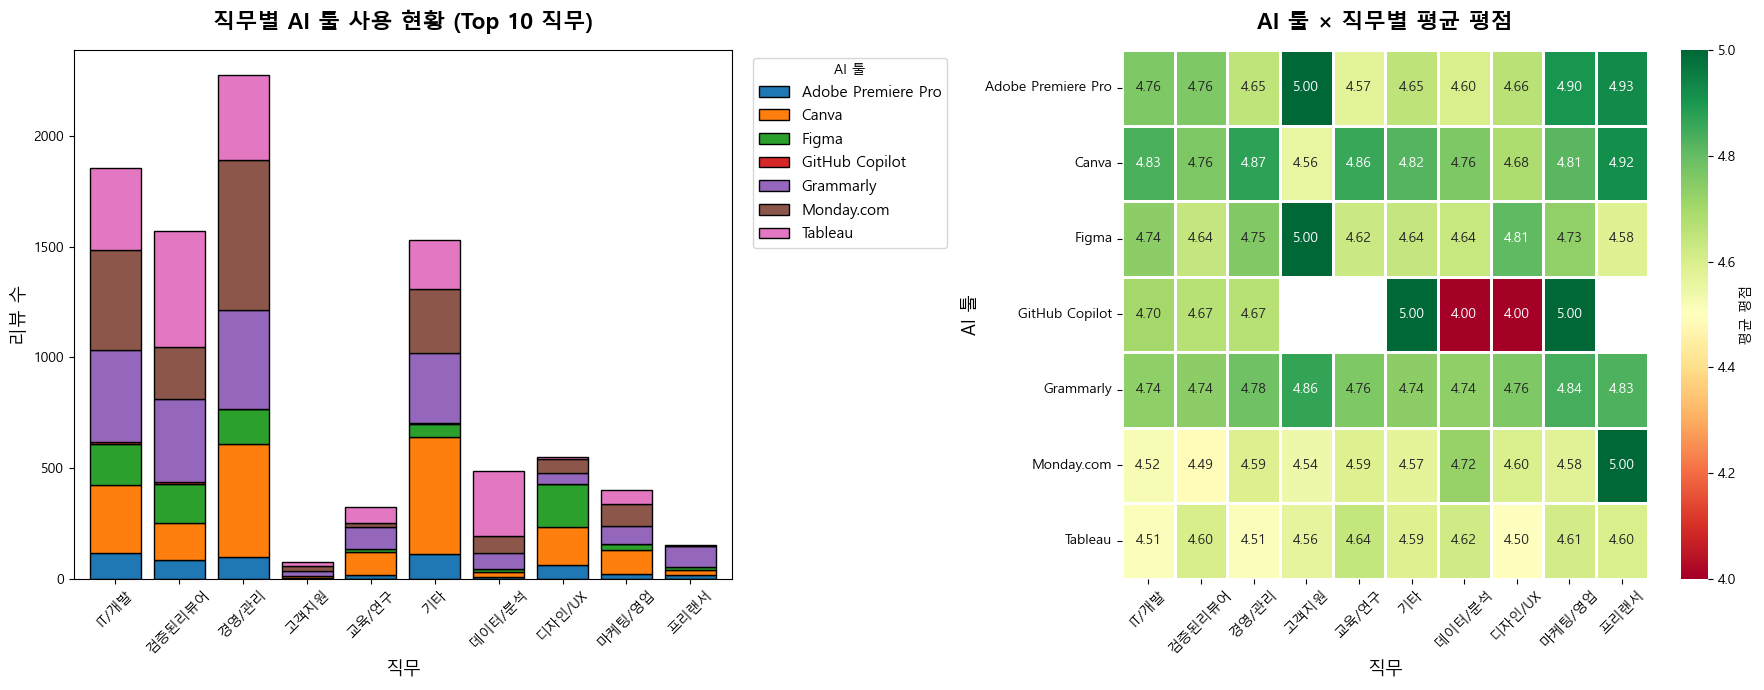


4단계 시각화 완료


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

csv_path = r"C:\Users\pc\ai_tool_analysis_ultra_final_20251213_221653.csv"
df = pd.read_csv(csv_path)

print(f"총 데이터: {len(df):,}개\n")

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

ax1 = axes[0]
top_jobs = df['job_category'].value_counts().head(10).index
df_filtered = df[df['job_category'].isin(top_jobs)]
job_tool_counts = df_filtered.groupby(['job_category', 'ai_tool']).size().unstack(fill_value=0)
job_tool_counts.plot(kind='bar', stacked=True, ax=ax1, edgecolor='black', width=0.8)
ax1.set_title('직무별 AI 툴 사용 현황 (Top 10 직무)', fontsize=16, weight='bold', pad=15)
ax1.set_xlabel('직무', fontsize=13)
ax1.set_ylabel('리뷰 수', fontsize=13)
ax1.legend(title='AI 툴', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=11)
ax1.tick_params(axis='x', rotation=45)

ax2 = axes[1]
heatmap_data = df_filtered.pivot_table(
    values='rating',
    index='ai_tool',
    columns='job_category',
    aggfunc='mean'
)
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax2, 
            cbar_kws={'label': '평균 평점'}, linewidths=1, linecolor='white',
            vmin=4.0, vmax=5.0)
ax2.set_title('AI 툴 × 직무별 평균 평점', fontsize=16, weight='bold', pad=15)
ax2.set_xlabel('직무', fontsize=13)
ax2.set_ylabel('AI 툴', fontsize=13)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
plt.savefig(f'ai_tool_core_analysis_{timestamp}.png', dpi=300, bbox_inches='tight')
print(f"시각화 저장: ai_tool_core_analysis_{timestamp}.png")
plt.show()

print("\n4단계 시각화 완료")
